## PREPROCESAMIENTO Y GENERACION DE MODELOS Y METRICAS Y CONCLUSIONES FINALES

Este Notebook contiene los siguientes 3 procesos de la tarea.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import string
from stop_words import get_stop_words
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import unicodedata
from num2words import num2words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
import random

%matplotlib inline 
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [2]:
# definimos una fucnion para cargar nuestro Data Set
def load_data_reviews(corpus_file):
    df_corpus = pd.read_json(corpus_file, lines=True)
    df_corpus = df_corpus.drop(['reviewerID', 'asin', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1)
    df_corpus.rename(columns={'overall': 'numEstrellas'}, inplace=True)    
    return df_corpus

In [3]:
# Creamos una funcion para procesar nuestro Data Set
import unicodedata
from num2words import num2words

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def nltk_cleaner(text, tokenizer, sw_list, lemmatizer):
    clean_text = list()
    
    # Eliminar acentos, etc
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Separar palabras eliminando signos de puntuación
    for word in tokenizer.tokenize(text):
        
        # Eliminar stop words
        if word not in sw_list:
            
        # Eliminar espacios sobrantes, convertir a minúsculas y lematizar
            clean_word = lemmatizer.lemmatize(word).lower().strip()
        
        # Convertir dígitos a palabras
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')

            clean_text.append(clean_word)
            
    return ' '.join(clean_text)

In [4]:
# Definimos variables para preprocecesar nuestros datos.
tokenizer = RegexpTokenizer(r'\w+')
sw_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [5]:
# Cargamos los datos a procesar
df = load_data_reviews('Digital_Music_5.json')
# Sacamos una copia
dfOriginal = df.copy()
# Por temas de recursos del equipo vamos a usar solo 10000 registros de los 64000 que son aproximadamente
df5000 = df[:5000]

In [6]:
# Procesmos los datos del DataFrame para limpiarlos mediante un Pipeline
for i in df5000.index:
    df5000.at[i,'reviewText'] = nltk_cleaner(df5000.at[i,'reviewText'], tokenizer, sw_list, lemmatizer)

In [7]:
df5000

reviewerName  \
0                                 Amaranth "music fan"   
1                                            bethtexas   
2                                          bob turnley   
3                                                Calle   
4                                          Cloud "..."   
...                                                ...   
4995                               allbritt@hiwaay.net   
4996                                   Amazon Customer   
4997                 Andre S. Grindle "Andre' Grindle"   
4998                      Barron Laycock "Labradorman"   
4999  beatlenik49 "Fixing A Hole Where The Rain Get...   

                                             reviewText  numEstrellas  \
0     it hard believe memory trees came eleven year ...             5   
1     a clasically styled introverted album memory t...             5   
2     i never thought enya would reach sublime heigh...             5   
3     this third review irish album i write today ot...             5   
4     enya despite successful recording artist broad...             4   
...                                                 ...           ...   
4995  if like m b need release it good not would m b...             5   
4996  this was a great lp in one thousand, nine hund...             5   
4997  being fairly new moody blues classic psychedel...             5   
4998  as earlier concept album opening cut final sev...             5   
4999  for first time moody blues reorganized group p...             5   

                                                summary  
0                               Enya's last great album  
1                              Enya at her most elegant  
2                                       The best so far  
3                          Ireland produces good music.  
4                                4.5; music to dream to  
...                                                 ...  
4995                              A balanced collection  
4996                GREAT 1970 LP & GREAT REMASTERED CD  
4997              The Moody Blues & The Meaning Of Life  
4998  Fascinating Wild Exploration of Environmentalism!  
4999                 The Moody Blues face The Dark Side  

[5000 rows x 4 columns]

In [8]:
reviews_text = []
reviews_sentiment = []

for x in df5000.index:
    reviews_text.append(df5000.at[x,'reviewText'])
    reviews_sentiment.append(df5000.at[x,'numEstrellas'])

dfData = pd.DataFrame({
    'comentario': reviews_text,
    'sentimiento': reviews_sentiment
})
dfData.dropna(subset=['comentario', 'sentimiento'], inplace=True)
dfData.reset_index(drop=True, inplace=True)

In [9]:
dfData

comentario  sentimiento
0     it hard believe memory trees came eleven year ...            5
1     a clasically styled introverted album memory t...            5
2     i never thought enya would reach sublime heigh...            5
3     this third review irish album i write today ot...            5
4     enya despite successful recording artist broad...            4
...                                                 ...          ...
4995  if like m b need release it good not would m b...            5
4996  this was a great lp in one thousand, nine hund...            5
4997  being fairly new moody blues classic psychedel...            5
4998  as earlier concept album opening cut final sev...            5
4999  for first time moody blues reorganized group p...            5

[5000 rows x 2 columns]

In [10]:
# Definimos una funcion para normalizar las etiquetas
def label_sentiment(row):
    if int(row['sentimiento']) < 3:
        return 0
    else:
        return 1

In [11]:
dfData['sentimiento_label'] = dfData.apply(lambda row: label_sentiment(row), axis=1)

In [12]:
dfData

comentario  sentimiento  \
0     it hard believe memory trees came eleven year ...            5   
1     a clasically styled introverted album memory t...            5   
2     i never thought enya would reach sublime heigh...            5   
3     this third review irish album i write today ot...            5   
4     enya despite successful recording artist broad...            4   
...                                                 ...          ...   
4995  if like m b need release it good not would m b...            5   
4996  this was a great lp in one thousand, nine hund...            5   
4997  being fairly new moody blues classic psychedel...            5   
4998  as earlier concept album opening cut final sev...            5   
4999  for first time moody blues reorganized group p...            5   

      sentimiento_label  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
4995                  1  
4996                  1  
4997                  1  
4998                  1  
4999                  1  

[5000 rows x 3 columns]

### Separamos los datos procesados en Train y Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    dfData['comentario'],
    dfData['sentimiento_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

### Creamos nuestra Bolsa de Palabras de N-Grams usando TF-IDF

In [14]:
# Realizamos una extraccion de Features

cv = TfidfVectorizer(
    ngram_range=(2, 3),
    strip_accents='ascii',
    max_df=0.95,
    min_df=3,
    max_features=3000
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=3000,
                min_df=3, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### Palabras con el TF-IDF en alguna review

In [15]:
# Preparamos los datos para entrenar nuestros modelos
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [16]:
X_train_

<3750x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 86206 stored elements in Compressed Sparse Row format>

In [17]:
i = random.randint(0, len(X_train))
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 15
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 15 words with highest TF_IDF in the review 3407:
                          tfidf
golden lady            0.352717
and seventy three      0.258296
seventy three          0.255049
hundred and seventy    0.245455
and seventy            0.245455
thousand nine hundred  0.218168
thousand nine          0.218168
one thousand nine      0.218168
nine hundred           0.217783
nine hundred and       0.217783
one thousand           0.217400
hundred and            0.212833
misstra know           0.167610
higher ground          0.150178
new york               0.135830

Top 15 words with lowest TF_IDF in the review 3407:
                       tfidf
really good         0.041878
seventy four        0.041878
song great          0.041638
two album           0.041521
album would         0.041179
and ninety five     0.039558
ninety five         0.038601
first time          0.038279
one song            0.038045
stevie wonder       0.035947
album ever          0.035595
hundred and eighty  0.029988
and e

## $\chi²$ scores

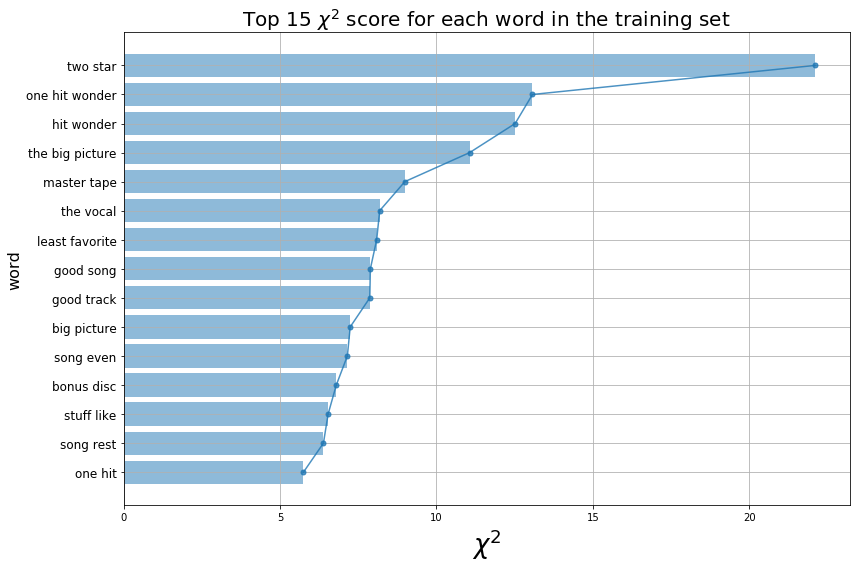

In [24]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Creamos nuestro Primer modelo usando Logistic Regresion

In [25]:
X_test_

<1250x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 26912 stored elements in Compressed Sparse Row format>

In [26]:
# Entrenamos el modelo
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9648
Accuracy for C=0.05: 0.9648
Accuracy for C=0.25: 0.9648
Accuracy for C=0.5: 0.9648
Accuracy for C=1: 0.9648
Accuracy for C=10: 0.9648
Accuracy for C=100: 0.9552
Accuracy for C=1000: 0.9432
Accuracy for C=10000: 0.9384


In [27]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[   6   38]
 [  39 1167]]

Classification report:
              precision    recall  f1-score   support

           0       0.13      0.14      0.13        44
           1       0.97      0.97      0.97      1206

    accuracy                           0.94      1250
   macro avg       0.55      0.55      0.55      1250
weighted avg       0.94      0.94      0.94      1250

Accuracy score:0.9384


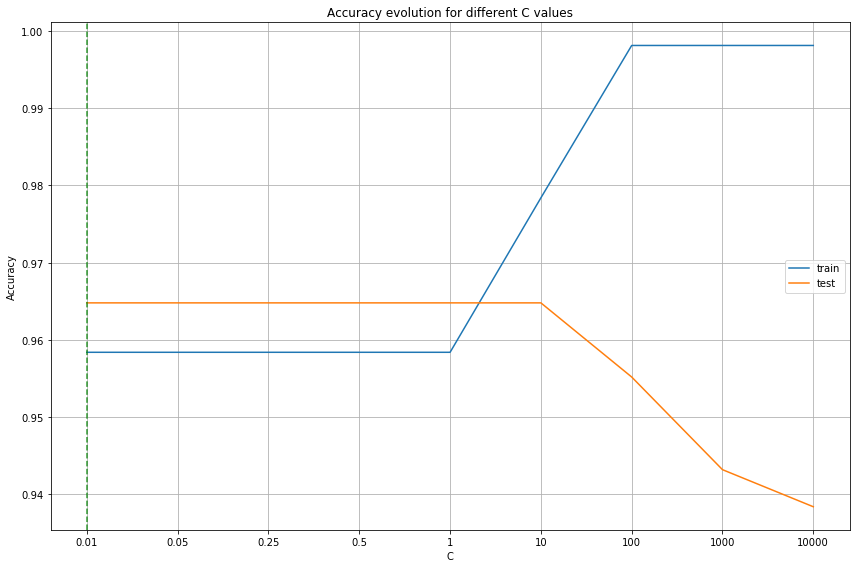

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [29]:
# Vamos a ver que tan bien predice nuestro modelo

In [30]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(dfData.iloc[review_index]['sentimiento_label']))
    r = dfData.iloc[review_index]['comentario']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [31]:
for i in random.sample(range(0, len(df5000)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 4969
Actual sentiment: 1
Prediction: [1]

Review no. 4034
Actual sentiment: 1
Prediction: [1]

Review no. 2795
Actual sentiment: 1
Prediction: [1]

Review no. 1306
Actual sentiment: 1
Prediction: [1]

Review no. 2512
Actual sentiment: 1
Prediction: [1]


In [32]:
regis = 578
print(dfData.iloc[regis]['comentario'])
print(dfData.iloc[regis]['sentimiento'])
print(dfData.iloc[regis]['sentimiento_label'])

i hate e forty but the track with two pac is good the two stars are only for that song don t buy this junk trust me
2
0


### Ahora vamos a crear un segundo modelo usando GradientBoostingClassifier

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train_, X_test_, y_train, y_test):        
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train_, y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train_, y_train),
            clf.score(X_test_, y_test)))
    
    return clf


clf2 = classify_gboost(X_train_, X_test_, y_train, y_test)

[GradientBoostingClassifier] Accuracy: train = 0.9658666666666667, test = 0.9616


In [91]:
print(clf2.predict(X_test_[1:]))

[1 1 1 ... 1 1 1]


### Ahora vamos a crear un tercer modelo modelo usando Deep Learning

In [92]:
vocabulary_size = 5000

In [101]:
from keras.preprocessing import sequence

max_words = 3000

#X_train = sequence.pad_sequences(X_train, maxlen=max_words)
#X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [102]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
#from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN

embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3000, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
batch_size = 64
num_epochs = 2

X_valid, y_valid = X_train_[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_[batch_size:], y_train[batch_size:]  # rest for training

model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Train on 3686 samples, validate on 64 samples
Epoch 1/2
3686/3686 [==============================] - 684s 185ms/step - loss: 0.1751 - accuracy: 0.9579 - val_loss: 0.0864 - val_accuracy: 0.9844
Epoch 2/2
3686/3686 [==============================] - 697s 189ms/step - loss: 0.1759 - accuracy: 0.9579 - val_loss: 0.0894 - val_accuracy: 0.9844


# Reporte de métricas y conclusiones

Despues de este procesamiento y Analisis de los datos tenemos las siguientes conclusiones:

1.- Es importante trabajar con Bi-grams y tri-grams, con el objetivo de visualizar de mejor menera frases que den mas sentido a lo que se esta hablando en el Data Set.

2.- Se procesaron 3 Algoritmos con diferentes metricas obteniendo diferentes resultados por ejemplo:

.- Modelo Logistic Regresion> nos dio un 94% de accuracy
.- Modelo GradientBoostingClassifier nos dio un 96% de accuracy
.- Modelo de Deep Learning usando LSTM y con dos epocas de entrenamiento finalmente nos dio 98% de accuracy

Claro de esto se puede ver que el entrenar un modelo de deep learning es mas costoso computacionalmente y los resultados son casi similares, con lo cual podemos concluir que dependiendo del problema a enfrentar y del costo beneficio cualqueira de las 3 implementaciones estarian bien.

